In [2]:
from mesa import Agent, Model

from mesa.time import RandomActivation

from mesa.datacollection import DataCollector

# matplotlib lo usaremos crear una animación de cada uno de los pasos del modelo.
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
plt.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams['animation.embed_limit'] = 2**128

import numpy as np
import pandas as pd

In [37]:
class Coche(Agent):
    def __init__(self, unique_id, model, x, y):
        super().__init__(unique_id, model)
        
        # Posición del coche
        self.position = np.array((x,y), dtype=np.float64)
        
        # Valor de la velocidad y aceleración del coche
        #vel = (np.random.rand() - 0.5) * 10
        #acc = (np.random.rand() - 0.5)/2
        
        # Vector de velocidad y aceleración del coche
        self.check_orientation()
        
    def step(self):
        self.check_limits()
        self.check_velocity()
        
        self.position = self.position + self.velocity
        #self.velocity = self.velocity + self.acceleration
        
        """
        print("agent: " + str(self.unique_id)) 
        print("posicion = " + str(self.position[0]) + " " + str(self.position[1]))
        print("velocidad = " + str(self.velocity[0]) + " " + str(self.velocity[1]))
        print("aceleracion = " + str(self.acceleration[0]) + " " + str(self.acceleration[1]))
        """

    def check_orientation(self):
        # Horizontal de derecha a izquierda
        if 0.0 <= self.position[0] <= 10.0 and 0.0 <= self.position[1] <= 2.0:
            vel = -1
            #acc = vel/2
            self.velocity = np.array((vel, 0), dtype=np.float64)
            #self.acceleration = np.array((acc, 0), dtype=np.float64)
            
        # Vertical de arriba hacia abajo
        elif -2.0 <= self.position[0] <= 0.0 and 0.0 <= self.position[1] <= 10.0:
            vel = -1
            #acc = vel/2
            self.velocity = np.array((0, vel), dtype=np.float64)
            #self.acceleration = np.array((0, acc), dtype=np.float64)
        
        # Horizontal de izquierda a derecha
        elif -10.0 <= self.position[0] <= 0.0 and -2.0 <= self.position[1] <= 0.0:
            vel = 1
            #acc = vel/2
            self.velocity = np.array((vel, 0), dtype=np.float64)
            #self.acceleration = np.array((acc, 0), dtype=np.float64)
        
        # Vertical de abajo hacia arriba
        elif 0.0 <= self.position[0] <= 2.0 and -10.0 <= self.position[1] <= 0.0:
            vel = 1
            #acc = vel/2
            self.velocity = np.array((0, vel), dtype=np.float64)
            #self.acceleration = np.array((0, acc), dtype=np.float64)
            
    def check_limits(self):
        if self.position.flatten()[0] > 20:
            self.position[0] = -10
        elif self.position.flatten()[0] < -20:
            self.position[0] = 10
            
        if self.position.flatten()[1] > 20:
            self.position[1] = -10
        elif self.position.flatten()[1] < -20:
            self.position[1] = 10
            
    def check_velocity(self):
        if self.velocity.flatten()[0] != 0:
            if -5 < self.velocity.flatten()[0] < 0:
                self.velocity[0] = -2
            elif 0 < self.velocity.flatten()[0] < 5:
                self.velocity[0] = 2
            #self.acceleration[0] = self.velocity[0]/2
            
        elif self.velocity.flatten()[1] != 0:
            if -5 < self.velocity.flatten()[1] < 0:
                self.velocity[1] = -2
            elif 0 < self.velocity.flatten()[1] < 5:
                self.velocity[1] = 2
            #self.acceleration[1] = self.velocity[0]/2
                
        
    

In [38]:
def get_cars(model):
    result = []
    for agent in model.schedule.agents:
        result.append(agent.position)
    result = np.asarray(result)
    return result

class CarModel(Model):
    def __init__(self, N):
        self.num_agents = N
        self.schedule = RandomActivation(self)
        
        source = np.array([[10, 2], [0, 10], [-2, 10], [-10, 0], [-10, -2], [0, -10], [2, -10], [10, 0]])
        temp = []
        i = 0
        
        while i in range(self.num_agents):
            pos = np.random.randint(8)
            if pos in temp:
                continue
            x = source[pos][0]
            y = source[pos][1]
            a = Coche(i, self, x, y)
            self.schedule.add(a)
            
            temp.append(pos)
            i += 1
            
        self.datacollector = DataCollector(model_reporters = {"Coches" : get_cars})
            
    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()    
            

In [39]:
MAX_GENERATIONS = 20
N = 5

model = CarModel(N)

for i in range(MAX_GENERATIONS):
    model.step()

In [40]:
all_positions = model.datacollector.get_model_vars_dataframe()

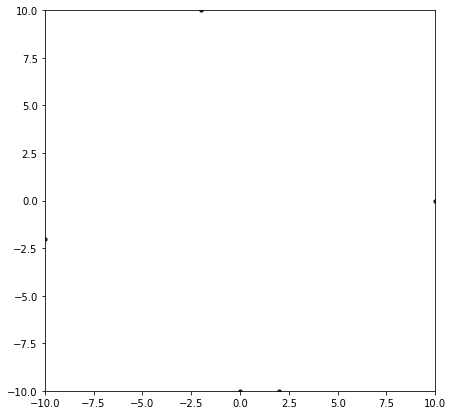

In [41]:
fig, ax = plt.subplots(figsize=(7,7))
scatter = ax.scatter(all_positions.iloc[0][0][:,0], all_positions.iloc[0][0][:,1],
                     s=10, cmap="jet", edgecolor="k")
ax.axis([-10, 10, -10, 10])
def update(frame_number):
    scatter.set_offsets(all_positions.iloc[frame_number][0])
    return scatter

anim = animation.FuncAnimation(fig, update, frames = MAX_GENERATIONS)

In [42]:
anim